# Experiment 002

We would like the Tetris emulator to model time-dependent phenomena like when a block lands and thus when a new block needs to spawn. Let's try and solve this problem separately with an RNN, which will inform the modifications we make to the main Tetris emulator model.

In [2]:
import os
from pathlib import Path

import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch.utils.data import Dataset
import numpy as np

In [158]:
class BlockLandingDataset(Dataset):
    def __init__(self, path: str):
        self.path = path
        if not os.path.exists(path):
            raise FileNotFoundError()
        with os.scandir(self.path) as it:
            entry: os.DirEntry = next(iter(it))
            _, self.ext = os.path.splitext(entry.name)
            self.highest_index = max((int(Path(file.path).stem) for file in it))

    def __len__(self):
        return self.highest_index

    def __getitem__(self, idx):
        file = os.path.join(self.path, f"{idx+1}{self.ext}")
        if not os.path.exists(file):
            raise IndexError()
        boards = np.load(file)
        x = boards[:2] # Just take the first two frames as that's what will be input to the main model
        b1 = boards[1] # We can identify a block landing by the fact that a block spawns in the next time step
        b2 = boards[2]
        y = (np.all(b1[0] == 0) & np.any(b2[0] == 1)).astype(np.float32)
        x, y = torch.tensor(x), torch.tensor(y)
        return x, y
        

In [159]:
dataset = BlockLandingDataset("data")
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

x, y = next(iter(dataloader))
print(x.shape, x.dtype)
print(y.shape, y.dtype)

torch.Size([4, 2, 22, 10]) torch.int32
torch.Size([4]) torch.float32


In [160]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [161]:
class BlockLandingModel(nn.Module):
    """Predicts whether a block has landed.

    Inputs:
        x: Tensor of int32 of shape (batch_size, seq_length, height, width). height = 22 and width = 10 are the dimensions of the game
           board. seq_length = 2 is the number of game board inputs. The entries should be 0 for empty cells and 1 for blocks.
    
    Returns: float32 scalar, logit for block landing prediction.
    """

    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(2, 5, 3)
        self.rnn = nn.GRU(5, 5)
        self.lin = nn.Linear(5, 1)

    def forward(self, x):
        x = F.one_hot(x.long(), 2) # One-hot encode the two cell classes
        x = x.type(torch.float) # Convert to floating-point
        x = x.permute((1, 0, 4, 2, 3)) # Move sequence to dimension 1 and channels/classes to dimension 2
        x1, x2 = x # Split up the two timesteps so we can apply convolution to them both separately
        x1 = F.relu(self.conv(F.pad(x1, (1, 1, 1, 1)))) # Pad height and width (the last 2 dimensions) with zeroes to represent the board boundaries
        x1 = F.avg_pool2d(x1, kernel_size=(22, 10)).squeeze(-1).squeeze(-1) # TODO: Ideally want global average pool that's size-independent
        x2 = F.relu(self.conv(F.pad(x2, (1, 1, 1, 1))))
        x2 = F.avg_pool2d(x2, kernel_size=(22, 10)).squeeze(-1).squeeze(-1)
        x = torch.concat((x1.unsqueeze(0), x2.unsqueeze(0)))
        x, rnn_state = self.rnn(x)
        x = x[-1] # Just take last predicted state
        logits = self.lin(x).squeeze(-1)
        return logits

In [162]:
model = BlockLandingModel().to(device)
print(model)

with torch.no_grad():
    X, y = next(iter(dataloader))
    logits = model(X)[0]
    preds = F.sigmoid(logits)
    print(f"Predicted states: {preds}")

BlockLandingModel(
  (conv): Conv2d(2, 5, kernel_size=(3, 3), stride=(1, 1))
  (rnn): GRU(5, 5)
  (lin): Linear(in_features=5, out_features=1, bias=True)
)
Predicted states: 0.5360490083694458


In [183]:
num_block_landings = sum(y for x, y in dataset)
print(f"Number of block landings: {num_block_landings}")

Number of block landings: 9.0


In [194]:
def train_loop(dataloader, model, loss_fn, optimizer):
    avg_loss = 0.0

    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):

        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        avg_loss += loss.item()

        if batch % 20 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    
    avg_loss /= size
    return avg_loss


def test_loop(dataloader, model, loss_fn):
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    recall = 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            classes = (pred >= 0).type(torch.float)
            correct += (classes == y).type(torch.float).mean().item()
            recall += ((classes == 1.0) & (y == 1.0)).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= num_batches
    recall /= num_block_landings
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Recall: {(100*recall):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return {
        "loss": test_loss,
        "acc": correct,
        "recall": recall
    }

In [195]:
learning_rate = 1e-2
batch_size = 4
epochs = 100

model = BlockLandingModel().to(device)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

loss_history = []
acc_history = []
recall_history = []

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    # Since our dataset represents the full set of possible states, we can safely use it for both training and testing
    epoch_loss = train_loop(dataloader, model, loss_fn, optimizer)
    loss_history.append(epoch_loss)
    # No need to plot test loss separately as in our case it's the same as training loss
    test_metrics = test_loop(dataloader, model, loss_fn)
    acc_history.append(test_metrics["acc"])
    recall_history.append(test_metrics["recall"])

print("Done!")

Epoch 1
-------------------------------
loss: 0.601624  [    4/  237]
loss: 0.532664  [   84/  237]
loss: 0.477071  [  164/  237]
Test Error: 
 Accuracy: 96.2%, Recall: 0.0%, Avg loss: 0.457551 

Epoch 2
-------------------------------
loss: 0.434938  [    4/  237]
loss: 0.392590  [   84/  237]
loss: 0.361378  [  164/  237]
Test Error: 
 Accuracy: 96.2%, Recall: 0.0%, Avg loss: 0.367338 

Epoch 3
-------------------------------
loss: 0.333029  [    4/  237]
loss: 0.304616  [   84/  237]
loss: 0.281191  [  164/  237]
Test Error: 
 Accuracy: 96.2%, Recall: 0.0%, Avg loss: 0.308433 

Epoch 4
-------------------------------
loss: 0.262875  [    4/  237]
loss: 0.566603  [   84/  237]
loss: 0.229864  [  164/  237]
Test Error: 
 Accuracy: 96.2%, Recall: 0.0%, Avg loss: 0.268599 

Epoch 5
-------------------------------
loss: 0.215386  [    4/  237]
loss: 0.202793  [   84/  237]
loss: 0.188874  [  164/  237]
Test Error: 
 Accuracy: 96.2%, Recall: 0.0%, Avg loss: 0.240920 

Epoch 6
------------

[]

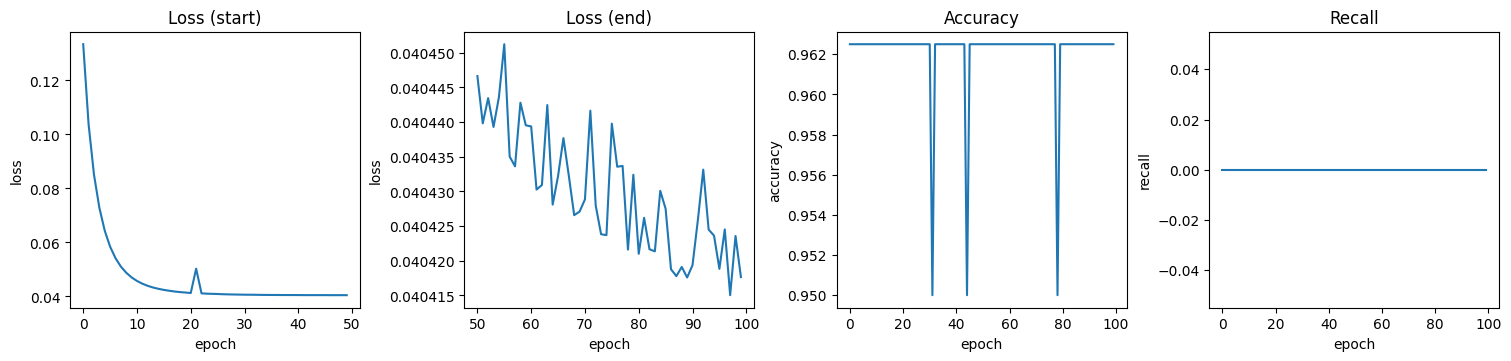

In [196]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 4, figsize=(15, 3.5), constrained_layout=True)
axs = axs.flatten()
ax_loss_1, ax_loss_2, ax_acc, ax_recall = axs

ax_loss_1.plot(loss_history[:epochs//2])
ax_loss_1.set_title("Loss (start)")
ax_loss_1.set_xlabel("epoch")
ax_loss_1.set_ylabel("loss")

ax_loss_2.plot(list(range(epochs//2, epochs)), loss_history[epochs//2:])
ax_loss_2.set_title("Loss (end)")
ax_loss_2.set_xlabel("epoch")
ax_loss_2.set_ylabel("loss")

ax_acc.plot(acc_history)
ax_acc.set_title("Accuracy")
ax_acc.set_xlabel("epoch")
ax_acc.set_ylabel("accuracy")

ax_recall.plot(recall_history)
ax_recall.set_title("Recall")
ax_recall.set_xlabel("epoch")
ax_recall.set_ylabel("recall")

plt.plot()

In [166]:
def show_prediction(idx):
    x, y = dataset[idx]
    x1, x2 = x
    pred = model(x.unsqueeze(0)).squeeze(0)

    fig, axs = plt.subplots(1, 2)
    fig.suptitle("Example")

    for ax in axs:
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

    axs[0].set_title("Step 0")
    axs[1].set_title("Step 1")

    axs[0].imshow(x1)
    axs[1].imshow(x2)

    print(f"Predicted: {pred >= 0}, Actual: {y == 1.0}")
    plt.show()

Showing prediction for example 91
Predicted: False, Actual: True


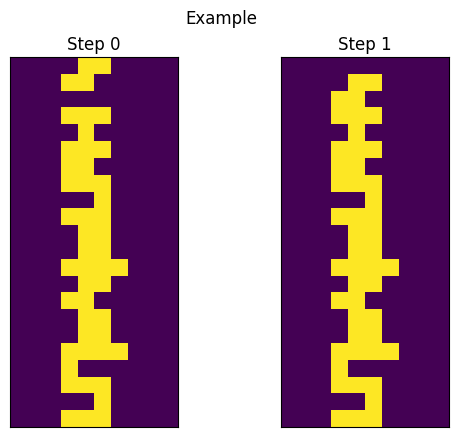

In [215]:
# Show a random prediction vs reality
import random

idx = random.randrange(len(dataset))
print(f"Showing prediction for example {idx+1}")
show_prediction(idx)

We can see from the training curves that the model just learns to classify all examples as "no block landed". This is likely because the dataset is heavily biased towards blocks not landing.

# Conclusion

In conclusion, training a model to detect block landing is not as simple as throwing the first architecture we think of at the same dataset and expecting it to work. This may be because the model is not complex enough to learn the mapping, or it could be the fact that the dataset is very imbalanced.

The next step is to prepare a more balanced dataset to see how the model performs.